# Table of Contents


>[Adv ML Final Project](#scrollTo=tdR67P3hD2GP)

>>[Goals](#scrollTo=tdR67P3hD2GP)

>>[Code](#scrollTo=tdR67P3hD2GP)

>>[Pre-processing and Data Cleaning](#scrollTo=KveNLb-BRXKh)

>>[Base Models and Augmentation](#scrollTo=jWmaR9TldxHZ)

>>>[ResNet50 Base Model](#scrollTo=MQz3vJzKUTAU)

>>>>[Comparison](#scrollTo=OVRsK8atd478)

>>>[VGG16 Model Augmentation](#scrollTo=mI3y1pq4UWw2)

>>>>[Comparsion](#scrollTo=lr-nMB-SdpcO)

>>[Hyperparameter Tuning](#scrollTo=9iziBl3f2z7G)

>>>[VGG16 Tuning](#scrollTo=iJqVfB6ehp4w)

>>>[ResNet50 Tuning](#scrollTo=NEEfuKnUm93k)

>>[Tensorflow Lite Conversion](#scrollTo=MVZ_9LdTwbX9)

>>>[Save the Optimized Model](#scrollTo=5AjDqJnn2dtE)

>>[Performance Evaluation](#scrollTo=e_Ps9pge_DZB)

>>[Conversion](#scrollTo=V5lWh_9y2nvM)

>>>>[Batched Image Performance](#scrollTo=NXO8WNEeWcR3)

>>>>[Single Image Performance](#scrollTo=ITWr3Bk6WOKr)



# Adv ML Final Project 

* Professor Parijat Dube
* DS-UA 301, Spring 2023
* May 4th, 2023
* Stanislav Kharchenko (sk8997) and Rashed Rifat (rmr557)

## Goals 

The goal of our project is to build a model that will predict the presence of COVID-19 using CAT Chest Scan images from a Kaggle Dataset. We plan to use ResNet50 as our project's base model, extending it with other hidden layers before classifying the image with a softmax prediction layer. Our project will focus on tuning the model to achieve the best performance possible by focusing on the learning rate, momentum, and optimizer parameters. Additionally, we will also convert our model to run on edge devices using TensorFlow Lite.

## Code 

## Pre-processing and Data Cleaning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = 'path/to/data'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D, Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

import time
import os

In [4]:
target_size = (224,224)
input_shape = (*target_size, 3)

In [5]:
# Load in data 
train_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_directory(directory=path + '/train', 
                                           target_size=target_size, subset='training')
val_data = train_gen.flow_from_directory(directory=path + '/train', 
                                           target_size=target_size,subset='validation')
test_data = test_gen.flow_from_directory(directory=path + '/test', 
                                         target_size=target_size)

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Base Models and Augmentation

### ResNet50 Base Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
# Load base ResNet50 model
num_clasess = 3

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_base.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
trainable_resnet_base = tf.keras.Sequential()
trainable_resnet_base.add(resnet_base)
trainable_resnet_base.add(tf.keras.layers.Flatten())
trainable_resnet_base.add(tf.keras.layers.Dense(3, activation='softmax'))

trainable_resnet_base.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])


early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)
callbacks_list = [early]

# Train model and save history
base_resnet_history = trainable_resnet_base.fit(
        train_data,
        validation_data = val_data,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
7/7 [==============================] - 122s 18s/step - loss: 5.0597 - acc: 0.5025 - val_loss: 8.1734 - val_acc: 0.2800
Epoch 2/50
7/7 [==============================] - 12s 2s/step - loss: 4.8637 - acc: 0.4826 - val_loss: 4.9766 - val_acc: 0.6800
Epoch 3/50
7/7 [==============================] - 12s 2s/step - loss: 3.3381 - acc: 0.6119 - val_loss: 2.9831 - val_acc: 0.3000
Epoch 4/50
7/7 [==============================] - 12s 2s/step - loss: 1.4118 - acc: 0.6318 - val_loss: 1.4171 - val_acc: 0.5400
Epoch 5/50
7/7 [==============================] - 12s 2s/step - loss: 0.8428 - acc: 0.7114 - val_loss: 0.6780 - val_acc: 0.6800
Epoch 6/50
7/7 [==============================] - 12s 2s/step - loss: 0.7105 - acc: 0.7065 - val_loss: 0.8872 - val_acc: 0.6200
Epoch 7/50
7/7 [==============================] - 12s 2s/step - loss: 0.6893 - acc: 0.8109 - val_loss: 1.3799 - val_acc: 0.6400
Epoch 8/50
7/7 [==============================] - 12s 2s/step - loss: 0.5780 - acc: 0.7960 - val_loss:

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();


ResNet50 Augmented Model

In [ ]:
class AugResNet50(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, optimizer_name = None, epochs = 10):
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name
        self.epochs = epochs
        self.model = None
        

    def fit(self, X, validation_data):
        
        

        resnet_aug = tf.keras.Sequential()
        resnet_aug.add(resnet_base)

        resnet_aug.add(GlobalAveragePooling2D())
        #resnet_aug.add(tf.keras.layers.Flatten())

        resnet_aug.add(tf.keras.layers.Dense(512))
        resnet_aug.add(tf.keras.layers.Activation('relu'))
        resnet_aug.add(tf.keras.layers.Dropout(0.05))

        resnet_aug.add(tf.keras.layers.Dense(512))
        resnet_aug.add(tf.keras.layers.Activation('relu'))
        #resnet_aug.add(tf.keras.layers.Dropout(0.05))

        #resnet_aug.add(tf.keras.layers.Dense(256))
        #resnet_aug.add(tf.keras.layers.Activation('relu'))
        #resnet_aug.add(tf.keras.layers.Dropout(0.4))

        resnet_aug.add(tf.keras.layers.Dense(3, activation='softmax'))

        resnet_aug.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                      metrics=['acc'])
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50_best.h5', 
                                                monitor='val_acc', verbose=1, 
                                                mode='max', save_best_only=True)

        early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=7)
        callbacks_list = [checkpoint, early]

        # Train model and save history
        history = resnet_aug.fit(
                train_data,
                validation_data = val_data,
                epochs=self.epochs, 
                shuffle=False, 
                verbose=True,
                callbacks=callbacks_list)

        self.model = resnet_aug
        self.history = history

        return self.history

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [ ]:
resnet_aug = AugResNet50(optimizer_name = "adam", epochs = 100)
aug_resnet_history = resnet_aug.fit(X = train_data, validation_data = val_data)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.1631 - acc: 0.3881
Epoch 1: val_acc improved from -inf to 0.44000, saving model to model/resnet50_best.h5
7/7 [==============================] - 18s 2s/step - loss: 1.1631 - acc: 0.3881 - val_loss: 1.1526 - val_acc: 0.4400
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1.0217 - acc: 0.5025
Epoch 2: val_acc improved from 0.44000 to 0.48000, saving model to model/resnet50_best.h5
7/7 [==============================] - 12s 2s/step - loss: 1.0217 - acc: 0.5025 - val_loss: 0.9691 - val_acc: 0.4800
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.0455 - acc: 0.5473
Epoch 3: val_acc improved from 0.48000 to 0.64000, saving model to model/resnet50_best.h5
7/7 [==============================] - 12s 2s/step - loss: 1.0455 - acc: 0.5473 - val_loss: 0.9052 - val_acc: 0.6400
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.8757 - acc: 0.6667
Epoch 4: val_acc did not impro

#### Comparison

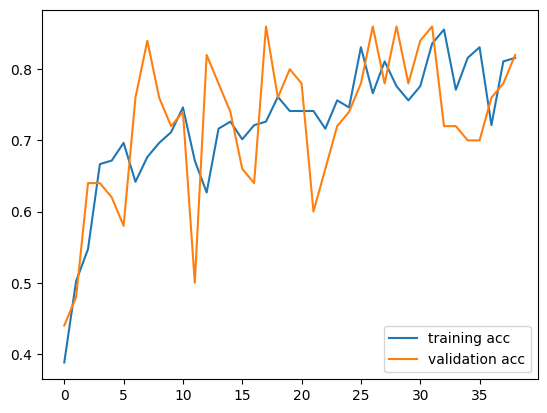

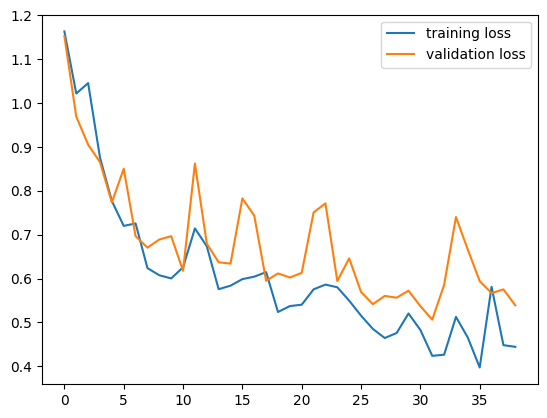

In [ ]:
plot_learning_curve(aug_resnet_history)

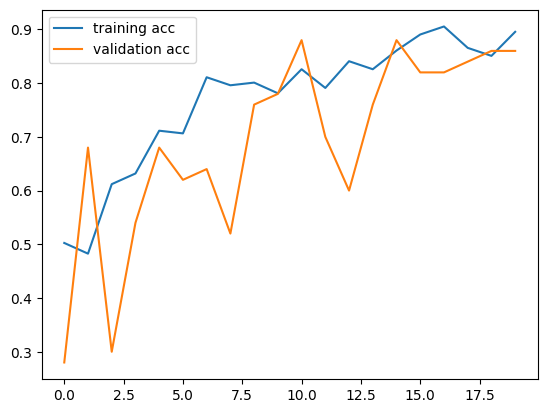

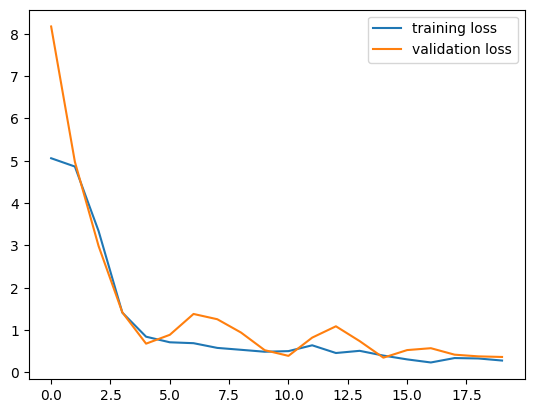

In [ ]:
plot_learning_curve(base_resnet_history)

### VGG16 Model Augmentation

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

# Load base model
vgg16_base = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
vgg16_base.trainable = False

In [ ]:
vgg16_aug = tf.keras.Sequential()
vgg16_aug.add(vgg16_base)

vgg16_aug.add(tf.keras.layers.GlobalAveragePooling2D())
vgg16_aug.add(tf.keras.layers.Flatten())

vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
vgg16_aug.add(tf.keras.layers.Dropout(0.5))

vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
vgg16_aug.add(tf.keras.layers.Dropout(0.5))

vgg16_aug.add(tf.keras.layers.Dense(3, activation='softmax'))

vgg16_aug.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

vgg16_aug.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_13  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 256)               131328    
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                     

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', 
                                                monitor='acc', verbose=1, 
                                                mode='max', save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                         mode="min",
                                         restore_best_weights=True, 
                                         patience=5)

callbacks_list = [checkpoint, early]

In [ ]:
# Get a trainable version of VGG16
trainable_vgg16_base = tf.keras.Sequential()
trainable_vgg16_base.add(vgg16_base)
trainable_vgg16_base.add(tf.keras.layers.Flatten())
trainable_vgg16_base.add(tf.keras.layers.Dense(3, activation='softmax'))

trainable_vgg16_base.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

# Train model and save history
base_history = trainable_vgg16_base.fit(
        train_data,
        validation_data = val_data,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.1237 - acc: 0.6169
Epoch 1: acc improved from -inf to 0.61692, saving model to model/vgg16_best.h5
7/7 [==============================] - 18s 3s/step - loss: 1.1237 - acc: 0.6169 - val_loss: 0.4306 - val_acc: 0.8200
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.2540 - acc: 0.9005
Epoch 2: acc improved from 0.61692 to 0.90050, saving model to model/vgg16_best.h5
7/7 [==============================] - 14s 2s/step - loss: 0.2540 - acc: 0.9005 - val_loss: 0.3576 - val_acc: 0.9000
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.1808 - acc: 0.9403
Epoch 3: acc improved from 0.90050 to 0.94030, saving model to model/vgg16_best.h5
7/7 [==============================] - 14s 2s/step - loss: 0.1808 - acc: 0.9403 - val_loss: 0.2826 - val_acc: 0.8200
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.0733 - acc: 0.9701
Epoch 4: acc improved from 0.94030 to 0.97015, saving m

In [ ]:
# Train our Augmented Model
aug_history = vgg16_aug.fit(
        train_data,
        validation_data = val_data,
        epochs=50, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 1.2086 - acc: 0.3930
Epoch 1: acc did not improve from 1.00000
7/7 [==============================] - 21s 3s/step - loss: 1.2086 - acc: 0.3930 - val_loss: 0.9901 - val_acc: 0.4400
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.0588 - acc: 0.4478
Epoch 2: acc did not improve from 1.00000
7/7 [==============================] - 13s 2s/step - loss: 1.0588 - acc: 0.4478 - val_loss: 0.9332 - val_acc: 0.5200
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.9445 - acc: 0.5274
Epoch 3: acc did not improve from 1.00000
7/7 [==============================] - 14s 2s/step - loss: 0.9445 - acc: 0.5274 - val_loss: 0.9084 - val_acc: 0.5800
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.8706 - acc: 0.5821
Epoch 4: acc did not improve from 1.00000
7/7 [==============================] - 14s 2s/step - loss: 0.8706 - acc: 0.5821 - val_loss: 0.8357 - val_acc: 0.6600
Epoch 5/50
7/7 [

#### Comparsion

In [ ]:
def plot_learning_curve(history, title):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel('Metrics')

    plt.legend()
    _ = plt.figure()

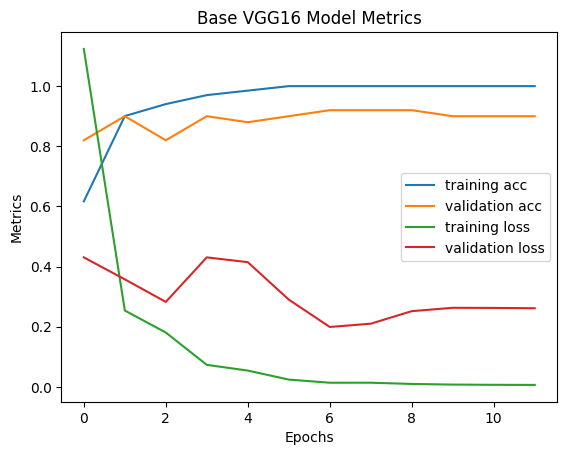

<Figure size 640x480 with 0 Axes>

In [ ]:
_ = plot_learning_curve(base_history, 'Base VGG16 Model Metrics')

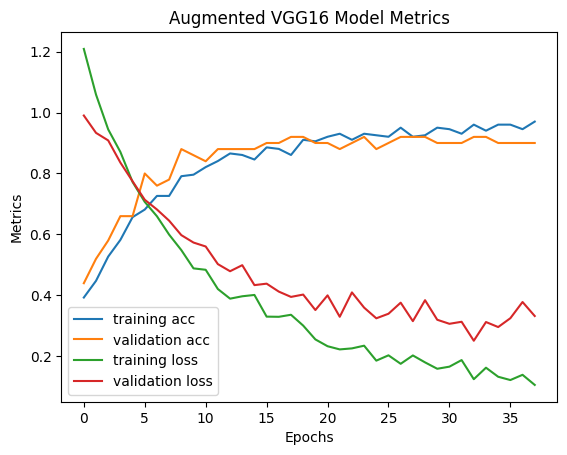

<Figure size 640x480 with 0 Axes>

In [ ]:
_ = plot_learning_curve(aug_history, 'Augmented VGG16 Model Metrics')

## Hyperparameter Tuning 

### VGG16 Tuning

In [ ]:
!pip install -U "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 51.5 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from keras.callbacks import EarlyStopping
import time
from pprint import pprint
from ray.tune.schedulers import HyperBandScheduler
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop, Adadelta

In [ ]:
def train_vgg16(config):
  # Set optimizers 
  optimizer_name = config.get('optimizer_name', 'adam')
  learning_rate = config.get('learning_rate', 0.001)
  momentum = config.get('momentum', 0.0)

  if optimizer_name == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'sgd':
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
  elif optimizer_name == 'adagrad':
    optimizer = Adagrad(learning_rate=learning_rate)
  else: # default case
    optimizer = Adam(learning_rate=learning_rate)
  
  # Create augmented model 
  vgg16_base = tf.keras.applications.vgg16.VGG16(
        weights='imagenet', 
        include_top=False,
        input_shape=input_shape
    )
  vgg16_base.trainable = False
  vgg16_aug = tf.keras.Sequential()
  vgg16_aug.add(vgg16_base)
  vgg16_aug.add(tf.keras.layers.GlobalAveragePooling2D())
  vgg16_aug.add(tf.keras.layers.Flatten())
  vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
  vgg16_aug.add(tf.keras.layers.Dropout(0.5))
  vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
  vgg16_aug.add(tf.keras.layers.Dropout(0.5))
  vgg16_aug.add(tf.keras.layers.Dense(3, activation='softmax'))
  vgg16_aug.compile(loss='categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])
  
  early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
  callbacks_list = [early, TuneReportCallback({"mean_accuracy": "accuracy"})]

  # get data 
  train_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
  test_gen = ImageDataGenerator(rescale=1/255)

  train_data = train_gen.flow_from_directory(directory=path + '/train', 
                                            target_size=target_size, subset='training')
  val_data = train_gen.flow_from_directory(directory=path + '/train', 
                                            target_size=target_size,subset='validation')
  test_data = test_gen.flow_from_directory(directory=path + '/test', 
                                          target_size=target_size)

  # Compile Train mdoel
  vgg16_aug.fit(train_data,
            validation_data = val_data, 
            epochs=50, verbose=False,  
            callbacks=callbacks_list)


In [ ]:
hyperband = HyperBandScheduler(max_t=200)

start_time = time.perf_counter()
vgg16_tuning_analysis = tune.run(
        train_vgg16,
        name="vgg16_exp",
        metric="mean_accuracy",
        mode="max",
        stop={
            "mean_accuracy": 0.95,
        },
        resources_per_trial={
            "gpu": 1
        },
        config={
            'learning_rate': tune.uniform(1e-4, 1e-2),
            'momentum': tune.uniform(0, 1),
            'optimizer_name': tune.choice(['adam', 'sgd', 'adagrad'])
        },
        scheduler=hyperband,
        num_samples=10
    )

(pid=2799) 2023-05-04 21:56:45.133574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=2799) 2023-05-04 21:56:47.565662: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=2799) Found 66 images belonging to 3 classes. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_vgg16_8c2f8_00000,2023-05-04_22-07-39,True,"0_learning_rate=0.0020,momentum=0.0731,optimizer_name=adagrad",d6af9e493096,50,0.656716,172.28.0.12,2799,653.384,13.1774,653.384,1683238059,50,8c2f8_00000
train_vgg16_8c2f8_00001,2023-05-04_22-23-07,True,"1_learning_rate=0.0078,momentum=0.5387,optimizer_name=adam",d6af9e493096,17,0.850746,172.28.0.12,10183,233.688,13.1022,233.688,1683238987,17,8c2f8_00001
train_vgg16_8c2f8_00002,2023-05-04_22-37-09,True,"2_learning_rate=0.0035,momentum=0.9040,optimizer_name=adagrad",d6af9e493096,50,0.736318,172.28.0.12,12630,649.285,11.4634,649.285,1683239829,50,8c2f8_00002
train_vgg16_8c2f8_00003,2023-05-04_22-51-57,True,"3_learning_rate=0.0093,momentum=0.6146,optimizer_name=adam",d6af9e493096,17,0.80597,172.28.0.12,19718,229.89,13.1373,229.89,1683240717,17,8c2f8_00003
train_vgg16_8c2f8_00004,2023-05-04_23-02-51,True,"4_learning_rate=0.0064,momentum=0.6267,optimizer_name=sgd",d6af9e493096,50,0.81592,172.28.0.12,21065,650.215,13.197,650.215,1683241371,50,8c2f8_00004
train_vgg16_8c2f8_00005,2023-05-04_23-13-55,True,"5_learning_rate=0.0054,momentum=0.1820,optimizer_name=sgd",d6af9e493096,50,0.686567,172.28.0.12,24626,658.94,12.2561,658.94,1683242035,50,8c2f8_00005
train_vgg16_8c2f8_00006,2023-05-04_22-13-47,True,"6_learning_rate=0.0073,momentum=0.0106,optimizer_name=adam",d6af9e493096,27,0.925373,172.28.0.12,6378,362.421,11.8212,362.421,1683238427,27,8c2f8_00006
train_vgg16_8c2f8_00007,2023-05-04_22-19-08,True,,d6af9e493096,23,0.950249,172.28.0.12,8397,315.047,13.192,315.047,1683238748,23,8c2f8_00007
train_vgg16_8c2f8_00008,2023-05-04_22-26-14,True,"8_learning_rate=0.0092,momentum=0.5234,optimizer_name=adam",d6af9e493096,13,0.80597,172.28.0.12,11543,182.254,12.4733,182.254,1683239174,13,8c2f8_00008
train_vgg16_8c2f8_00009,2023-05-04_22-48-00,True,"9_learning_rate=0.0043,momentum=0.8900,optimizer_name=adagrad",d6af9e493096,50,0.756219,172.28.0.12,16176,644.595,11.3805,644.595,1683240480,50,8c2f8_00009


(pid=6378) 2023-05-04 22:07:43.506316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=6378) 2023-05-04 22:07:45.952612: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=6378) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=8397) 2023-05-04 22:13:51.801911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=8397) 2023-05-04 22:13:55.075312: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=8397) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=10183) 2023-05-04 22:19:11.670480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=10183) 2023-05-04 22:19:14.866553: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=10183) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=11543) 2023-05-04 22:23:10.640299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=11543) 2023-05-04 22:23:13.064875: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=11543) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=12630) 2023-05-04 22:26:18.480014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=12630) 2023-05-04 22:26:21.903756: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=12630) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=16176) 2023-05-04 22:37:14.188505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=16176) 2023-05-04 22:37:16.800350: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=16176) Found 201 images belonging to 3 classes.
(train_vgg16 pid=16176) Found 50 images belonging to 3 classes.
(train_vgg16 pid=16176) Found 66 images belonging to 3 classes.


(pid=19718) 2023-05-04 22:48:05.263032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=19718) 2023-05-04 22:48:08.265557: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=19718) Found 201 images belonging to 3 classes.
(train_vgg16 pid=19718) Found 50 images belonging to 3 classes.
(train_vgg16 pid=19718) Found 66 images belonging to 3 classes.


(pid=21065) 2023-05-04 22:51:59.884142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=21065) 2023-05-04 22:52:02.345030: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=21065) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


(pid=24626) 2023-05-04 23:02:55.005611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train_vgg16 pid=24626) 2023-05-04 23:02:57.516843: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_vgg16 pid=24626) Found 201 images belonging to 3 classes.
(train_vgg16 pid=24626) Found 50 images belonging to 3 classes.
(train_vgg16 pid=24626) Found 66 images belonging to 3 classes.


2023-05-04 23:13:55,393	INFO tune.py:945 -- Total run time: 4635.96 seconds (4635.88 seconds for the tuning loop).


In [ ]:
best_trial = vgg16_tuning_analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.last_result["mean_accuracy"]

vgg16_results = {}
vgg16_results['vgg_16'] = {
    "time" : f'{round(time.perf_counter() - start_time, 4)} seconds',
    "best_model_params" : vgg16_tuning_analysis.best_config,
    "accuracy": best_accuracy
}

vgg16_results

{'vgg_16': {'time': '4636.2663 seconds',
  'best_model_params': {'learning_rate': 0.0028980417092137317,
   'momentum': 0.43991393898898634,
   'optimizer_name': 'adam'},
  'accuracy': 0.9502487778663635}}

### ResNet50 Tuning

In [ ]:
def train_resnet50(config):
  # Set optimizers 
  optimizer_name = config.get('optimizer_name', 'adam')
  learning_rate = config.get('learning_rate', 0.001)
  momentum = config.get('momentum', 0.0)

  if optimizer_name == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'sgd':
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
  elif optimizer_name == 'adagrad':
    optimizer = Adagrad(learning_rate=learning_rate)
  else: # default case
    optimizer = Adam(learning_rate=learning_rate)

  resnet_base.trainable = False
  resnet_aug = tf.keras.Sequential()
  resnet_aug.add(resnet_base)

  resnet_aug.add(GlobalAveragePooling2D())

  resnet_aug.add(tf.keras.layers.Dense(512))
  resnet_aug.add(tf.keras.layers.Activation('relu'))
  resnet_aug.add(tf.keras.layers.Dropout(0.05))

  resnet_aug.add(tf.keras.layers.Dense(512))
  resnet_aug.add(tf.keras.layers.Activation('relu'))

  resnet_aug.add(tf.keras.layers.Dense(3, activation='softmax'))

  resnet_aug.compile(loss='categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])

  early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=7)
  callbacks_list = [early, TuneReportCallback({"mean_accuracy": "accuracy"})]

  # get data 
  train_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
  test_gen = ImageDataGenerator(rescale=1/255)

  train_data = train_gen.flow_from_directory(directory=path + '/train', 
                                            target_size=target_size, subset='training')
  val_data = train_gen.flow_from_directory(directory=path + '/train', 
                                            target_size=target_size,subset='validation')
  test_data = test_gen.flow_from_directory(directory=path + '/test', 
                                          target_size=target_size)

   # Train model and save history
  history = resnet_aug.fit(
          train_data,
          validation_data = val_data,
          epochs=50,
          shuffle = False,
          verbose=False,
          callbacks=callbacks_list)


In [ ]:
hyperband = HyperBandScheduler(max_t=200)

start_time = time.perf_counter()
resnet50_tuning_analysis = tune.run(
        train_resnet50,
        name="resnet50_exp",
        metric="mean_accuracy",
        mode="max",
        stop={
            "mean_accuracy": 0.95,
        },
        resources_per_trial={
            "gpu": 1
        },
        config={
            'learning_rate': tune.uniform(1e-4, 1e-2),
            'momentum': tune.uniform(0, 1),
            'optimizer_name': tune.choice(['adam', 'sgd', 'adagrad'])
        },
        scheduler=hyperband,
        num_samples=10
    )

2023-05-09 00:51:43,273	WARNING worker.py:1986 -- Warning: The actor ImplicitFunc is very large (90 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-05-09 00:51:43,495	WARNING util.py:244 -- The `start_trial` operation took 13.792 s, which may be a performance bottleneck.
(pid=60266) 2023-05-09 00:51:46.673055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=60266) 2023-05-09 00:51:49.299866: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=60266) Found 66 images belonging to 3 classes. [repeated 5x across cluster]


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_resnet50_602b3_00000,2023-05-09_01-01-22,True,"0_learning_rate=0.0035,momentum=0.3885,optimizer_name=sgd",19e987ff1893,50,0.671642,172.28.0.12,60266,556.833,11.0773,556.833,1683594082,50,602b3_00000
train_resnet50_602b3_00001,2023-05-09_01-27-35,True,"1_learning_rate=0.0069,momentum=0.3156,optimizer_name=sgd",19e987ff1893,50,0.597015,172.28.0.12,69481,570.913,11.0991,570.913,1683595655,50,602b3_00001
train_resnet50_602b3_00002,2023-05-09_01-45-18,True,"2_learning_rate=0.0015,momentum=0.6601,optimizer_name=adam",19e987ff1893,37,0.756219,172.28.0.12,76517,430.451,11.1042,430.451,1683596718,37,602b3_00002
train_resnet50_602b3_00003,2023-05-09_01-55-15,True,"3_learning_rate=0.0075,momentum=0.4116,optimizer_name=adagrad",19e987ff1893,50,0.646766,172.28.0.12,79241,563.685,10.5766,563.685,1683597315,50,602b3_00003
train_resnet50_602b3_00004,2023-05-09_02-13-38,True,"4_learning_rate=0.0059,momentum=0.2347,optimizer_name=sgd",19e987ff1893,43,0.577114,172.28.0.12,86203,482.018,10.884,482.018,1683598418,43,602b3_00004
train_resnet50_602b3_00005,2023-05-09_02-22-05,True,"5_learning_rate=0.0090,momentum=0.4131,optimizer_name=sgd",19e987ff1893,42,0.671642,172.28.0.12,89238,474.429,11.134,474.429,1683598925,42,602b3_00005
train_resnet50_602b3_00006,2023-05-09_01-07-32,True,"6_learning_rate=0.0031,momentum=0.8356,optimizer_name=sgd",19e987ff1893,30,0.656716,172.28.0.12,63740,337.06,10.8332,337.06,1683594452,30,602b3_00006
train_resnet50_602b3_00007,2023-05-09_01-17-30,True,"7_learning_rate=0.0020,momentum=0.4559,optimizer_name=adagrad",19e987ff1893,50,0.661692,172.28.0.12,65942,565.605,11.1252,565.605,1683595050,50,602b3_00007
train_resnet50_602b3_00008,2023-05-09_01-37-34,True,"8_learning_rate=0.0044,momentum=0.4949,optimizer_name=adagrad",19e987ff1893,50,0.701493,172.28.0.12,73010,565.682,10.8791,565.682,1683596254,50,602b3_00008
train_resnet50_602b3_00009,2023-05-09_02-05-02,True,"9_learning_rate=0.0056,momentum=0.7656,optimizer_name=adagrad",19e987ff1893,50,0.671642,172.28.0.12,82740,553.986,10.8789,553.986,1683597902,50,602b3_00009


2023-05-09 01:01:33,401	WARNING util.py:244 -- The `start_trial` operation took 10.847 s, which may be a performance bottleneck.
(pid=63740) 2023-05-09 01:01:36.700387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=63740) 2023-05-09 01:01:39.264126: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=63740) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 01:07:43,388	WARNING util.py:244 -- The `start_trial` operation took 10.781 s, which may be a performance bottleneck.
(pid=65942) 2023-05-09 01:07:46.571949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=65942) 2023-05-09 01:07:49.254730: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=65942) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 01:17:42,757	WARNING util.py:244 -- The `start_trial` operation took 11.064 s, which may be a performance bottleneck.
(pid=69481) 2023-05-09 01:17:46.095021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=69481) 2023-05-09 01:17:48.709573: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=69481) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 01:27:46,791	WARNING util.py:244 -- The `start_trial` operation took 11.014 s, which may be a performance bottleneck.
(pid=73010) 2023-05-09 01:27:50.032776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=73010) 2023-05-09 01:27:52.784459: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=73010) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 01:37:45,802	WARNING util.py:244 -- The `start_trial` operation took 10.954 s, which may be a performance bottleneck.
(pid=76517) 2023-05-09 01:37:48.971366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=76517) 2023-05-09 01:37:51.628019: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=76517) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 01:45:29,843	WARNING util.py:244 -- The `start_trial` operation took 10.942 s, which may be a performance bottleneck.
(pid=79241) 2023-05-09 01:45:32.995239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=79241) 2023-05-09 01:45:35.670217: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=79241) Found 50 images belonging to 3 classes. [repeated 2x across cluster]


2023-05-09 01:55:26,957	WARNING util.py:244 -- The `start_trial` operation took 10.993 s, which may be a performance bottleneck.
(pid=82740) 2023-05-09 01:55:30.185241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=82740) 2023-05-09 01:55:32.840799: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=82740) Found 50 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 02:05:14,076	WARNING util.py:244 -- The `start_trial` operation took 11.055 s, which may be a performance bottleneck.
(pid=86203) 2023-05-09 02:05:17.210179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=86203) 2023-05-09 02:05:19.837227: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=86203) Found 66 images belonging to 3 classes. [repeated 4x across cluster]


2023-05-09 02:13:49,138	WARNING util.py:244 -- The `start_trial` operation took 11.075 s, which may be a performance bottleneck.
(pid=89238) 2023-05-09 02:13:52.389476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=89238) 2023-05-09 02:13:55.110857: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train_resnet50 pid=89238) Found 66 images belonging to 3 classes. [repeated 3x across cluster]


2023-05-09 02:22:05,735	INFO tune.py:945 -- Total run time: 5550.08 seconds (5547.30 seconds for the tuning loop).


In [ ]:
best_trial = resnet50_tuning_analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.last_result["mean_accuracy"]

resnet50_results = {}
resnet50_results['resnet50'] = {
    "time" : f'{round(time.perf_counter() - start_time, 4)} seconds',
    "best_model_params" : resnet50_tuning_analysis.best_config,
    "accuracy": best_accuracy
}

resnet50_results

{'resnet50': {'time': '5595.942 seconds',
  'best_model_params': {'learning_rate': 0.0014873710286773295,
   'momentum': 0.6600652342095472,
   'optimizer_name': 'adam'},
  'accuracy': 0.7562189102172852}}

## Tensorflow Lite Conversion

### Save the Optimized Model

Here, we select VGG16 as the better model and save the weights for later on.

In [6]:
optimizer = Adam(learning_rate=0.0028980417092137317)

# Create augmented model 
vgg16_base = tf.keras.applications.vgg16.VGG16(
      weights='imagenet', 
      include_top=False,
      input_shape=input_shape
  )
vgg16_base.trainable = False
vgg16_aug = tf.keras.Sequential()
vgg16_aug.add(vgg16_base)
vgg16_aug.add(tf.keras.layers.GlobalAveragePooling2D())
vgg16_aug.add(tf.keras.layers.Flatten())
vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
vgg16_aug.add(tf.keras.layers.Dropout(0.5))
vgg16_aug.add(tf.keras.layers.Dense(256, activation='relu'))
vgg16_aug.add(tf.keras.layers.Dropout(0.5))
vgg16_aug.add(tf.keras.layers.Dense(3, activation='softmax'))
vgg16_aug.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
callbacks_list = [early]

# get data 
train_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
test_gen = ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_directory(directory=path + '/train', 
                                          target_size=target_size, subset='training')
val_data = train_gen.flow_from_directory(directory=path + '/train', 
                                          target_size=target_size,subset='validation')
test_data = test_gen.flow_from_directory(directory=path + '/test', 
                                        target_size=target_size)

# Compile Train mdoel
vgg16_aug.fit(train_data,
          validation_data = val_data, 
          epochs=50, verbose=True,  
          callbacks=callbacks_list)


58889256/58889256 [==============================] - 1s 0us/step
Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Epoch 1/50
7/7 [==============================] - 69s 8s/step - loss: 1.1889 - accuracy: 0.3532 - val_loss: 1.0526 - val_accuracy: 0.3800
Epoch 2/50
7/7 [==============================] - 15s 2s/step - loss: 1.0003 - accuracy: 0.4975 - val_loss: 0.8773 - val_accuracy: 0.6600
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 0.7959 - accuracy: 0.6269 - val_loss: 0.7711 - val_accuracy: 0.7400
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 0.6585 - accuracy: 0.7015 - val_loss: 0.7025 - val_accuracy: 0.7000
Epoch 5/50
7/7 [==============================] - 14s 2s/step - loss: 0.5854 - accuracy: 0.7264 - val_loss: 0.6557 - val_accuracy: 0.8200
Epoch 6/50
7/7 [==============================] - 14s 2s/step - loss: 0.5293 - accuracy: 0.8010 - val_loss: 0.5883 - val_acc

In [7]:
vgg16_aug.save('vgg16_aug_optimized')

In [8]:
!zip -r 'vgg16_aug_optimized' '/content/vgg16_aug_optimized'

  adding: content/vgg16_aug_optimized/ (stored 0%)
  adding: content/vgg16_aug_optimized/keras_metadata.pb (deflated 96%)
  adding: content/vgg16_aug_optimized/assets/ (stored 0%)
  adding: content/vgg16_aug_optimized/fingerprint.pb (stored 0%)
  adding: content/vgg16_aug_optimized/variables/ (stored 0%)
  adding: content/vgg16_aug_optimized/variables/variables.index (deflated 66%)
  adding: content/vgg16_aug_optimized/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/vgg16_aug_optimized/saved_model.pb (deflated 90%)


## Performance Evaluation

In [12]:
from sklearn.metrics import accuracy_score, precision_score, \
                            roc_auc_score, roc_curve, f1_score, auc, recall_score
from sklearn.preprocessing import label_binarize

test_data.reset()
true_labels = []
num_steps = len(test_data)
for _ in range(num_steps):
  _, labels = test_data.next()
  true_labels.extend(labels.argmax(axis=1))
test_data.reset()

In [13]:
predictions = vgg16_aug.predict(test_data)
true_labels = label_binarize(true_labels, classes=np.arange(3))

3/3 [==============================] - 2s 408ms/step


In [14]:
predicted_labels = np.argmax(predictions, axis=1)
precision = precision_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')

In [15]:
# Calculate AUC and ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average AUC
fpr_micro, tpr_micro, _ = roc_curve(true_labels.ravel(), predictions.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Calculate F1 score
f1 = f1_score(np.argmax(true_labels, axis=1), predicted_labels, average='weighted')

In [18]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Micro-average AUC: {roc_auc_micro}")
print(f"F1 score: {f1}")

Precision: 0.9214365881032547
Recall: 0.8939393939393939
Micro-average AUC: 0.983356290174472
F1 score: 0.8905886720200067


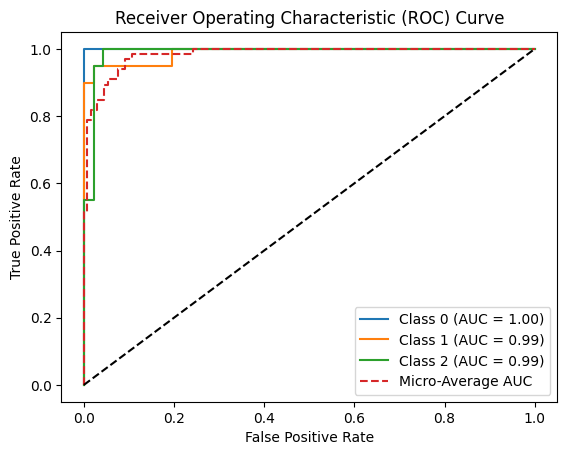

In [19]:
# Plot ROC curves
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr_micro, tpr_micro, label='Micro-Average AUC', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Conversion
Here we convert the saved model to its "lite" version and compare results.

In [20]:
!pip install psutil
import psutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
def get_directory_size_mb(directory):
    total_size = 0
    MB = (1024 * 1024)

    if os.path.isfile(directory):
      return os.path.getsize(directory) / KB

    for path, dirs, files in os.walk(directory):
        for file_ in files:
            file_path = os.path.join(path, file_)
            total_size += os.path.getsize(file_path)

    return total_size / MB

In [22]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(vgg16_aug)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('vgg16.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='vgg16.tflite')
interpreter.allocate_tensors()

#### Batched Image Performance 

Comparing performace for a batch fo 32 images, predicted iteratively through the batch. 

In [23]:
# Fetch a single image from the test data
index = 0
images, labels = test_data[index]  
y_true  = np.argmax(labels, axis=1)

In [29]:
# Profie the original model for a single image 
aug_model_output = []
start_time, start_memory = time.time(), psutil.Process().memory_info().rss

for img in images:
  img = tf.expand_dims(img, axis=0)
  aug_model_output.append(vgg16_aug.predict(img, verbose=False)[0])

end_time, end_memory = time.time(), psutil.Process().memory_info().rss

# Calculate Accuracy 
y_pred_aug = np.argmax(aug_model_output, axis=1)
correct_predictions = np.sum(y_true == y_pred_aug)
total_samples = y_true.shape[0]
accuracy = correct_predictions / total_samples

print(f'Time: {round(end_time - start_time, 4)} s')
print(f'Memory Used: {round((end_memory - start_memory) / (1024 * 1024), 10)}')
print(f"Accuracy: {accuracy}")
print(f"Model Weight Size: 61.8 MB")

Time: 2.536 s
Memory Used: 0.44140625
Accuracy: 0.95
Model Weight Size: 61.8 MB


In [30]:
# Test the converted TensorFlow Lite model
tflite_model_output = []
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
start_time, start_memory = time.time(), psutil.Process().memory_info().rss

for img in images:
  img = tf.expand_dims(img, axis=0)
  interpreter.set_tensor(input_details[0]['index'], img)
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]['index'])
  tflite_model_output.append(result[0])

end_time, end_memory = time.time(), psutil.Process().memory_info().rss

# Calculate Accuracy 
y_pred_tflite = np.argmax(tflite_model_output, axis=1)
correct_predictions = np.sum(y_true == y_pred_tflite)
total_samples = y_true.shape[0]
accuracy = correct_predictions / total_samples

print(f'Time: {round(end_time - start_time, 4)} s')
print(f'Memory Used: {round((end_memory - start_memory) / (1024 * 1024), 10)}')
print(f"Accuracy: {accuracy}")
print(f"Model Weights Size: {get_directory_size_mb('/content/resnet50.tflite')}")

Time: 32.7876 s
Memory Used: 0.0
Accuracy: 0.95
Model Weights Size: 0.0


#### Single Image Performance

In [26]:
# Fetch a single image from the test data
index = 1
single_image, labels = test_data[index]  

In [31]:
# Profie the original model for a single image 
aug_model_output = []
start_time, start_memory = time.time(), psutil.Process().memory_info().rss

img = tf.expand_dims(single_image[0], axis=0)
aug_model_output.append(vgg16_aug.predict(img, verbose=False)[0])

end_time, end_memory = time.time(), psutil.Process().memory_info().rss

print(f'Time: {round(end_time - start_time, 4)} s')
print(f'Memory Used: {round((end_memory - start_memory) / (1024 * 1024), 10)} MB')

Time: 0.1114 s
Memory Used: 0.25109375 MB


In [28]:
# Test the converted TensorFlow Lite model
tflite_model_output = []
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
start_time, start_memory = time.time(), psutil.Process().memory_info().rss

img = tf.expand_dims(single_image[0], axis=0)
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]['index'])
tflite_model_output.append(result[0])

end_time, end_memory = time.time(), psutil.Process().memory_info().rss

print(f'Time: {round(end_time - start_time, 4)} s')
print(f'Memory Used: {round((end_memory - start_memory) / (1024 * 1024), 10)} MB')

Time: 1.2891 s
Memory Used: 0.0 MB
